In [143]:
from torch.utils.data import SubsetRandomSampler
import torch
import cv2
import os
import torchvision.transforms as T
from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt
import math
from torch.utils.data import Dataset
import numpy as np
import time    

In [2]:
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [20, 10]

In [4]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2 - cropx//2
    starty = y//2 - cropy//2    
    return img[:, starty:starty+cropy, startx:startx+cropx]

In [5]:
def crop(img, x1, x2, y1, y2):
    return img[:, y1 : y2, x1 : x2]

In [6]:
class Crop:
    def __init__(self, x1, x2, y1, y2):
        self.x1 = x1
        self.x2 = x2
        self.y1 = y1
        self.y2 = y2
    
    def __call__(self, img):
        return crop(img, self.x1, self.x2, self.y1, self.y2)

class BGRtoRGB:
    def __call__(self, frame):
        return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    
class RGBtoBGR:
    def __call__(self, frame):
        return cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)    
    
class ToOpenCV:
    def __call__(self, frame):
        return frame.permute(1, 2, 0).numpy()

In [43]:
class AnglesDataset(Dataset):
    def __init__(self, filename, degrees=False):
        self.degrees = degrees
        pitch = []
        yaw = []
        with open(filename, 'r') as f:
            for line in f:
                line = line.split()      
                if degrees:
                    pitch.append(math.degrees(float(line[0])))
                    yaw.append(math.degrees(float(line[1])))
                else:
                    pitch.append(float(line[0]))
                    yaw.append(float(line[1]))
                    
        self.pitch = np.asarray(pitch)
        self.yaw = np.asarray(yaw)
        
    def __getitem__(self, idx):
        return self.pitch[idx], self.yaw[idx]
    
    def __len__(self):
        return len(self.pitch)

In [87]:
def read_n_frames(video, n, transform=None):
    cap = cv2.VideoCapture(v)
    frames = []
    if cap.isOpened():
        for i in range(n):
            ret, frame = cap.read()
            if not ret:
                break

            if transform is not None:
                frame = transform(frame)

            frames.append(frame)
        
    cap.release()
    return frames


def read_frames(video, transform=None):
    cap = cv2.VideoCapture(video)
    frames = []
    while cap.isOpened():      
        ret, frame = cap.read()
        if not ret:
            break

        if transform is not None:
            frame = transform(frame)

        frames.append(frame)
        
    cap.release()
    return frames

In [9]:
#SBAGLIATA
def flip_angles_deg(angles):
    return (360 - angles[0], 360 - angles[1])
def flip_angles_rad(angles):
    return (math.tau - angles[0], math.tau - angles[1])

In [129]:
#rotate a column vector

def get_rotation(angle, degree=True):
    if degree:
        angle = math.radians(angle)
    matrix = np.array([[math.cos(angle), -math.sin(angle)],
                      [math.sin(angle), math.cos(angle)]])
    return matrix

def get_inv_rotation(angle, degree=True):
    matrix = get_rotation(angle, degree).T
    return matrix


def rotate_v(v, angle, degree=True):
    return get_rotation(angle, degree) @ v

def inv_rotate_v(v, angle, degree=True):
    return get_inv_rotation(angle, degree) @ v

def draw_arrow(frame, v, pos, color=(255,255,255)):
    v[1] *= -1
    cv2.arrowedLine(frame, tuple(np.ceil(pos).astype(int)), tuple(np.ceil(pos + v).astype(int)), color, 2)

In [10]:
def crop_height(img, y1, y2):
    return img[y1:y2, :, :]

In [11]:
def show(img, t=None):
    if t:
        img = t(img)
    plt.imshow(img.permute(1, 2, 0))

In [12]:
height = 874
width = 1164

h_div = 3
w_div = 3

n_height = int(height // h_div)
n_width = int(width // w_div)

In [192]:
video = "4"
videos_dir = os.path.join("calib_challenge", "labeled")
video_path = os.path.join(videos_dir, video + ".hevc")
angles_file = os.path.join(videos_dir, video + ".txt")

trf_resize = T.Resize((n_height, n_width))

transform = T.Compose([BGRtoRGB(), T.ToTensor(), trf_resize])


angles = AnglesDataset(angles_file, degrees=True)

In [15]:
# frames = read_n_frames(v, 20, transform)

In [195]:
del frames

In [196]:
# del frames
frames = read_frames(video_path)

In [197]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
original = (10, height - 200)
fontScale              = 1
fontColor              = (255,255,255)
lineType               = 2


wait_key = 101
i = 0
direction = 1

to_open_cv = T.Compose([ToOpenCV(), RGBtoBGR()])
manual = False

#camera vector based straight road. (Yaw)
scale_factor = 200
angle_factor = 20
camera_v = np.array([0, 1]).T * scale_factor
camera_v = rotate_v(camera_v, angles[0][1] * angle_factor, angles.degrees)
pos = np.array([int(width / 2), int(height - 300)]).T

fixed_v = np.array([0, 1]).T * scale_factor
fixed_color = (0, 0, 255)

v_color = (255, 255, 255)
while i < len(frames) and i >= 0:
    frame = np.copy(frames[i])
    
    cv2.putText(frame, f"{i} {angles[i]}", 
        original, 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    if not math.isnan(angles[i][1]):
        v = np.copy(camera_v)
        v = inv_rotate_v(v, angles[i][1] * angle_factor, angles.degrees)
        draw_arrow(frame, v, pos, v_color)
#     camera = np.copy(camera_v)
#     fixed = np.copy(fixed_v)
#     draw_arrow(frame, camera, pos)
#     draw_arrow(frame, fixed, pos, fixed_color)
    
    cv2.putText(frame, f"{v}", 
        (10, height-100), 
        font, 
        fontScale,
        fontColor,
        lineType)
    
    cv2.imshow("frame", frame)

    key = cv2.waitKey(wait_key)
    if key == ord('q'):
        break
    elif key == ord('p'):
        while cv2.waitKey(500) != ord('p'):
            continue
    elif key == ord('e'): #increase speed
        if wait_key > 1: 
            wait_key -= 20
    elif key == ord('w'): #decrease speed
        if wait_key < 5001:
            wait_key += 20
    elif key == ord('a'): #forward one frame
        i -= 1
    elif key == ord('d'): #back one frame
        i += 1
    elif key == ord('m'): #manual skip
        manual = not manual
    elif key == ord('f'): #forward
        direction = 1
    elif key == ord('r'): #reverse 
        direction = -1

    if not manual:
        i += direction


        
cv2.destroyAllWindows()

In [62]:
n_height - 60

231

In [19]:
frame = frames[0]

In [17]:
trf_rot = T.RandomRotation((10, 10))
trf_crop = Crop(25, 350, 125, 231)
trf_translate = T.RandomAffine(0, (0.1, 0.1))

aug_trf = T.Compose([trf_translate, trf_crop])

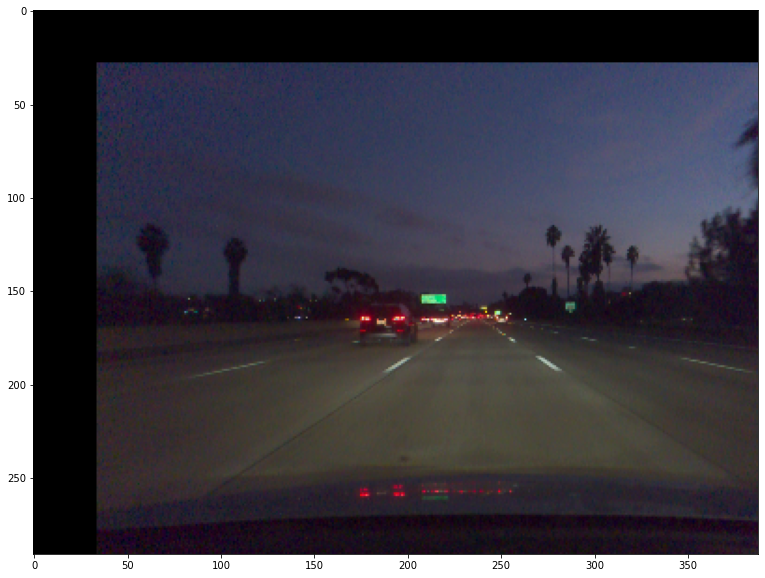

In [91]:
show(frame, trf_translate)

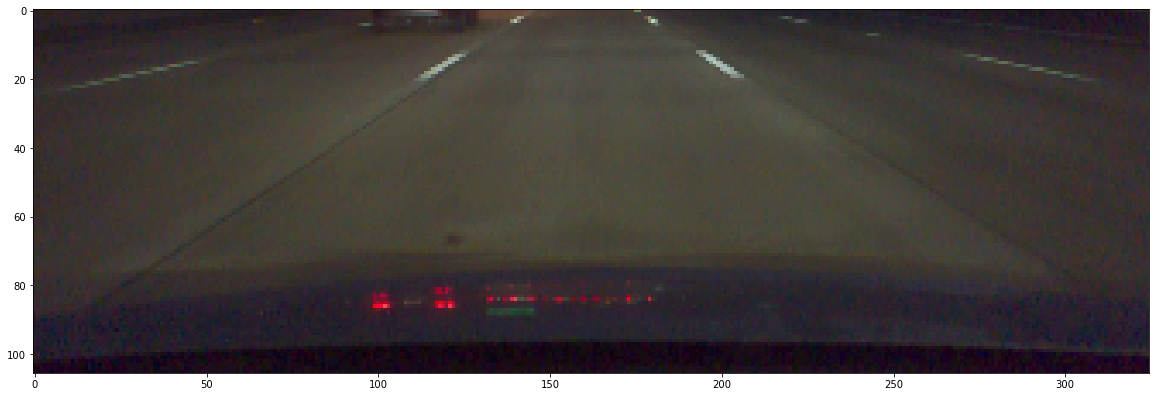

In [103]:
show(frame, aug_trf)

In [20]:
trf_crop(frame).shape

torch.Size([3, 106, 325])

In [61]:
aug_trf(frame).shape

torch.Size([3, 125, 325])

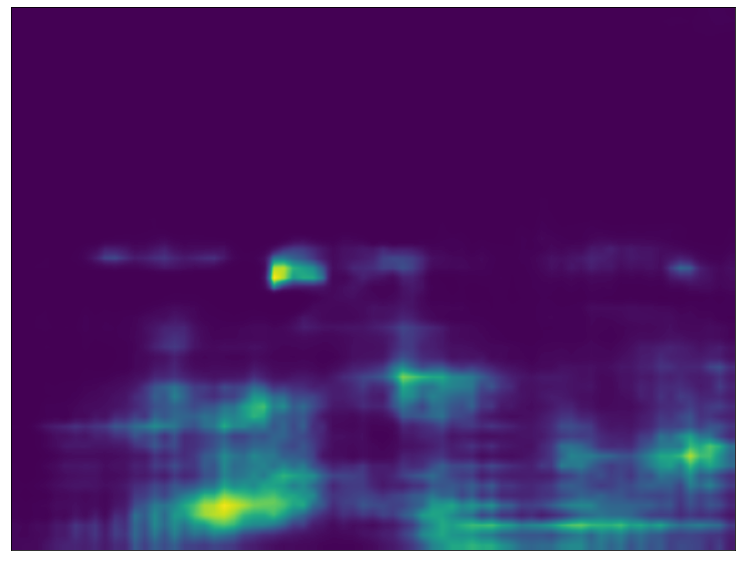

In [24]:
show(imgs)